In [1]:

%matplotlib notebook

from math import *
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import pyvisgraph as vg


In [2]:
import pyzbar.pyzbar as pyzbar
import cv2
import yaml
import time
import os
import EKF_SLAM as ekf
import QRDB as qrdb



In [90]:

from picar import front_wheels, back_wheels
from picar.SunFounder_PCA9685 import Servo
import picar
from time import sleep
picar.setup()
length_ofedge=0.16
bw = back_wheels.Back_Wheels()
fw = front_wheels.Front_Wheels()
pan_servo = Servo.Servo(1)
tilt_servo = Servo.Servo(2)
picar.setup()
# - left
# + right
# to be measured directly on the picar
offset = 6
# pan_servo.offset = 10
# tilt_servo.offset = 0
initial_angle_fw=90+offset
bw.speed = 0
fw.turn(initial_angle_fw)
pan_servo.write(90)
tilt_servo.write(100)

# motor_speed = 70
# 70i*3=127cm, i= 1.27/210 m/s
# 70i=1.27/3=0.42333333333333334m/s
# 40i~100i=0.2419047619~0.60476190476 m/s
L=0.14
true_speed_unit=0.15/35
MAX_SPEED=100*true_speed_unit
MIN_SPEED=70*true_speed_unit
MIN_RADIAN=1.0/180*pi
MAX_TRUN_LEFT=(initial_angle_fw-120)*pi/180
MAX_TRUN_RIGHT=(initial_angle_fw-60)*pi/180

def ctl_straight(speed,dt,st):
    """constant speed straight control driver connected to PiCar-V""" 
    bw.stop()
    fw.turn(initial_angle_fw)
    sleep(st)
    bw.speed=speed
    bw.backward()
    sleep(dt)
    bw.stop()
    sleep(st)
def ctl_constant_turning(speed,angle,dt,st):
    """constant speed constant turning control driver connected to PiCar-V""" 
    bw.stop()
    fw.turn(angle)
    sleep(st)
    bw.speed=speed
    bw.backward()
    sleep(dt)
    bw.stop()
    sleep(st)

DEBUG "back_wheels.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "PCA9685.py": Set debug off
DEBUG "front_wheels.py": Set debug off
DEBUG "front_wheels.py": Set wheel debug off
DEBUG "Servo.py": Set debug off


In [3]:
def safe_arange(start, stop, step):
    return step * np.arange(start / step, stop / step)
def hline(xa,xb,y,stepsize,ox,oy):
    for i in safe_arange(xa, xb, stepsize):
        ox.append(i)
        oy.append(y)
def vline(ya,yb,x,stepsize,ox,oy):
    for i in safe_arange(ya, yb, stepsize):
        ox.append(x)
        oy.append(i)
def sqaure(x_min,x_max,y_min,y_max,stepsize,ox,oy):
    hline(x_min,x_max,y_min,stepsize,ox,oy)
    hline(x_min,x_max,y_max,stepsize,ox,oy)
    vline(round(y_min+stepsize,3),y_max,x_min,stepsize,ox,oy)
    vline(y_min,round(y_max+stepsize,3),x_max,stepsize,ox,oy)
def vonoroi_roadmap(ox,oy,polygon):
    oxy = np.vstack((ox, oy)).T
    vor = scipy.spatial.Voronoi(oxy)
    G = nx.Graph()
    overall_edges=[]
    for vpair in vor.ridge_vertices:
        if vpair[0] >= 0 and vpair[1] >= 0:
            v0 = vor.vertices[vpair[0]]
            v1 = vor.vertices[vpair[1]]
            if not (polygon.contains(Point(v0)) or polygon.contains(Point(v1))):
                overall_edges.append(([v0[0], v1[0]],[v0[1], v1[1]]))
                G.add_node(vpair[0],coord=v0)
                G.add_node(vpair[1],coord=v1)
                G.add_edge(vpair[0], vpair[1],weight=np.linalg.norm(v0-v1))
    return G,overall_edges
    
def vonoroi_planner(waypoints,G):
    idx_to_node={i: list(G.nodes())[i] for i in range(len(list(G.nodes())))}
    effective_coords=np.array([G.nodes(data=True)[i]['coord'] for i in list(G.nodes())])
    neigh = NearestNeighbors(1)
    neigh.fit(effective_coords)
    overall_path=np.array([]).reshape(-1,2)
    for i in range(len(waypoints)):
        if i != waypoints.shape[0]-1:
            way1=waypoints[[i],:]
            way2=waypoints[[i+1],:]
            start_node_idx=neigh.kneighbors(way1, 1, return_distance=False)[0][0]
            start_node_coord=G.node[idx_to_node[start_node_idx]]['coord'].reshape(1,-1)
            stop_point1_idx=neigh.kneighbors(way2, 1, return_distance=False)[0][0]
            stop_point1_coord=G.node[idx_to_node[stop_point1_idx]]['coord'].reshape(1,-1)
            path=nx.shortest_path(G, source=idx_to_node[start_node_idx], target=idx_to_node[stop_point1_idx],weight='weight')
            path_coords=np.array([G.nodes(data=True)[i]['coord'] for i in path])
            path_coords=np.concatenate((way1,start_node_coord,path_coords,stop_point1_coord,way2),axis=0)
            overall_path=np.concatenate((overall_path,path_coords),axis=0)
    return overall_path
def plot_vonoroi(ax,overall_edges):
    for a,b in overall_edges:
        vo=ax.plot(a, b, 'b', linewidth=2)
    return vo
    

In [4]:
waypoints=np.array([[0.75,-0.75],[0,0.65],[-1,0]])

ox = []
oy = []

sqaure(-1.5,1.5,-1.5,1.3,0.01,ox,oy)

sqaure(-0.45,0.45,-0.28,0.28,0.01,ox,oy)
polygon = Polygon([(-0.45, -0.28), (-0.45, 0.28), (0.45, 0.28), (0.45, -0.28)])
G,overall_edges=vonoroi_roadmap(ox,oy,polygon)
overall_path=vonoroi_planner(waypoints,G)

<IPython.core.display.Javascript object>


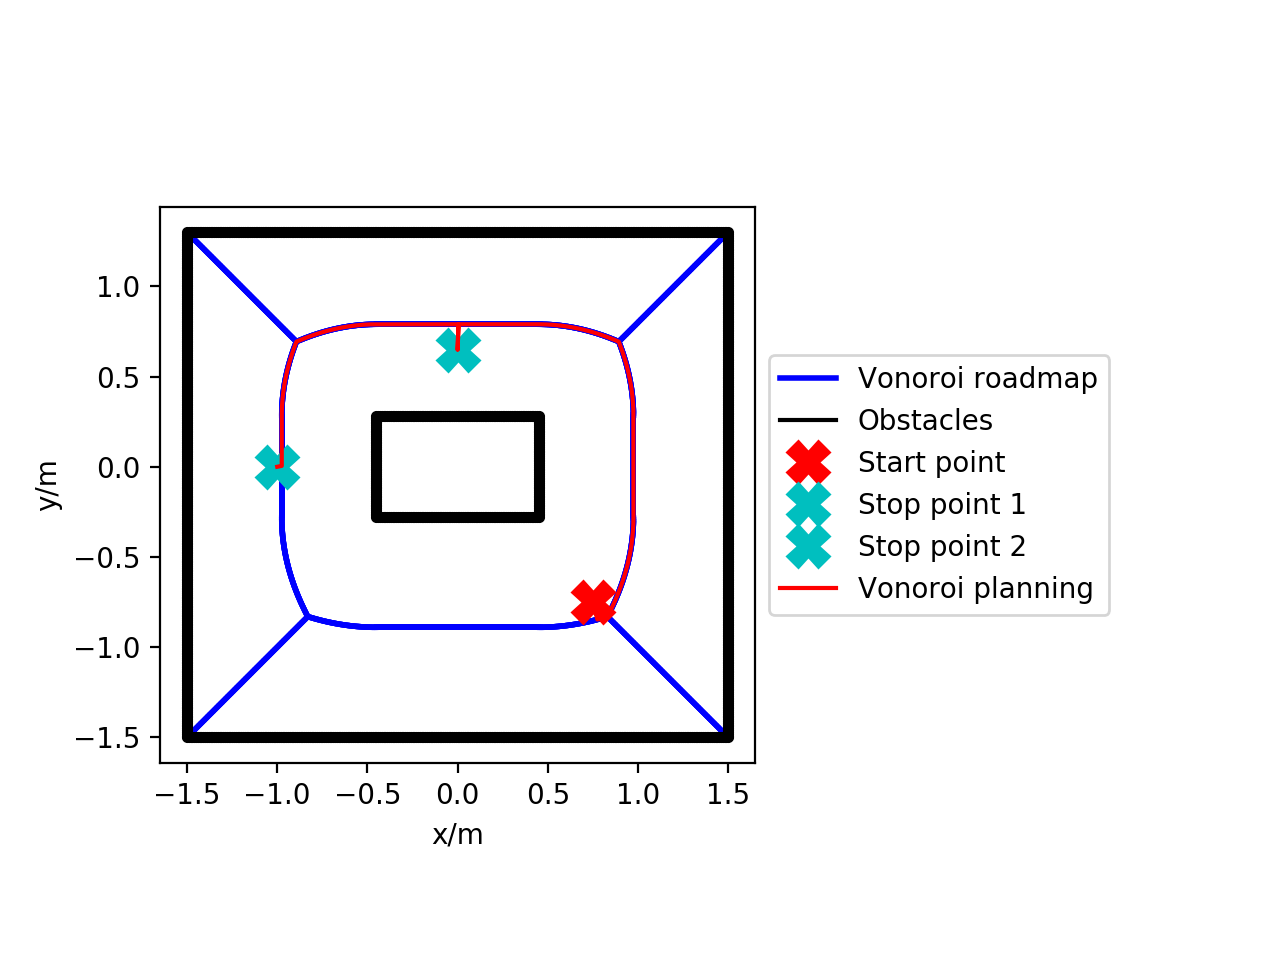

Text(0,0.5,u'y/m')

In [5]:
fig = plt.figure()
ax = plt.subplot(111)
vo=plot_vonoroi(ax,overall_edges)
ax.plot(ox, oy, ".k")
bo=ax.plot(ox[0], oy[0], "k")
st=ax.plot(waypoints[0][0],waypoints[0][1], "Xr",markersize=15)
d1t=ax.plot(waypoints[1][0],waypoints[1][1], "Xc",markersize=15)
d2t=ax.plot(waypoints[2][0],waypoints[2][1], "Xc",markersize=15)
pt=ax.plot(overall_path[:,0], overall_path[:,1],'r')
ax.set_aspect('equal')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
ax.legend((vo[0],bo[0],st[0],d1t[0],d2t[0],pt[0]),('Vonoroi roadmap','Obstacles','Start point','Stop point 1','Stop point 2','Vonoroi planning'),loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x/m')
plt.ylabel('y/m')

In [6]:
plt.savefig('./figures/vonoroi_planning.eps', format='eps', dpi=1000)



In [11]:
objp = np.array([[-length_ofedge/2, -length_ofedge/2, 0.],
       [-length_ofedge/2, length_ofedge/2, 0.],
       [length_ofedge/2, length_ofedge/2, 0.],
       [length_ofedge/2, -length_ofedge/2, 0.]])
with open('calibration.yaml') as f:
    loadeddict = yaml.load(f)

mtx = np.array(loadeddict.get('camera_matrix'))
dist = np.array(loadeddict.get('dist_coeff'))
# axis = np.float32([[0.1,0,0], [0,0.1,0], [0,0,-0.1]]).reshape(-1,3)
mtx_fool=np.array([[625, 0.0, 303.790334392223],
                  [0.0, 625, 303.790334392223],
                  [0.0, 0.0, 1.0]])
cap = cv2.VideoCapture(0)


# W: set of external landmarks
W = np.array([[-1.5,-1.5,-1.5,0,0,1.5,1.5,1.5],[-1.5,0,1.3,-1.5,1.3,-1.5,0,1.3]]) # Type 'help cloister' for help


In [68]:
W[:,[7]]=np.vstack([1.06711243,1.02522592])

R = np.vstack([0.75,0,pi/2])

In [81]:
# robot pose

name_dis_bearing,frame=qrdb.QR_bearing_dis(cap,mtx,dist,mtx_fool,objp,sample_rate=20,draw=False)
observed=name_dis_bearing.keys()


In [197]:
for i in range(4):
    ctl_straight(70,1,1)
ctl_constant_turning(70,initial_angle_fw-30,2.0,1)
fw.turn(initial_angle_fw+30)
ctl_straight(70,1.5,1)    

ctl_constant_turning(70,initial_angle_fw+10,1,1)


ctl_straight(70,1,1)

ctl_constant_turning(70,initial_angle_fw-30,2.0,1)


ctl_straight(70,0.5,1)